In [ ]:
from google.colab import drive
from google.colab import files 


drive.mount("/content/gdrive")
print(os.getcwd())
os.chdir("/content/gdrive/My Drive/AML2021")
print(os.getcwd())

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os

import tensorflow as tf

from tensorflow.keras import backend, optimizers, models, applications, metrics
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
import tensorflow.keras.utils as utils

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

print(x_train.shape, y_train.shape)

(16324, 299, 299, 3) (16324, 2)


In [4]:
# Adapt Constants
date = time.strftime("%d-%m-%Y_%H-%M-%S")
MODEL_NAME = f"ResNet101-{date}"
os.makedirs(f'models/{MODEL_NAME}', exist_ok = True) 
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 2
INITIAL_EPOCH = 0
NUM_EPOCHS = 120
OPTIMIZER = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
BATCH_SIZE = 16

LRS = ReduceLROnPlateau(monitor='val_auroc', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_auroc', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


MC = ModelCheckpoint(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")
MC_BEST = ModelCheckpoint(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/{MODEL_NAME}/{MODEL_NAME}.log')
TB = TensorBoard(log_dir=f'models/{MODEL_NAME}/logs')

METRICS = [metrics.AUC(name='auroc', curve='ROC'),
           metrics.CategoricalAccuracy(name='accuracy'),
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
           ]

# Load data
assert(backend.image_data_format()=='channels_last')

# Model: preprocess, base model, top layer/classifier
i = Input(shape=INPUT_SHAPE)
x = applications.resnet.preprocess_input(i)


base_model = applications.resnet.ResNet101(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
x = base_model(x)

x = GlobalAveragePooling2D(name='avg_pool')(x)
o = Dense(NUM_CLASSES, activation='softmax', name=f'fc{NUM_CLASSES}')(x)

model = models.Model(inputs=i, outputs=o)

# Train Model
if INITIAL_EPOCH != 0:
	model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
else:
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=METRICS)

model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split = 0.2, callbacks = [MC, MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)

Epoch 1/120
817/817 [==============================] - 425s 509ms/step - loss: 1.1992 - auroc: 0.5518 - accuracy: 0.5375 - precision: 0.5375 - recall: 0.5375 - val_loss: 0.6601 - val_auroc: 0.6606 - val_accuracy: 0.6101 - val_precision: 0.6101 - val_recall: 0.6101

Epoch 00001: saving model to models/ResNet101-23-09-2021_14-22-13\latest-ResNet101-23-09-2021_14-22-13.hdf5

Epoch 00001: val_auroc improved from inf to 0.66061, saving model to models/ResNet101-23-09-2021_14-22-13\best-ResNet101-23-09-2021_14-22-13.hdf5
Epoch 2/120
817/817 [==============================] - 413s 505ms/step - loss: 0.6143 - auroc: 0.7097 - accuracy: 0.6383 - precision: 0.6383 - recall: 0.6383 - val_loss: 0.5887 - val_auroc: 0.7464 - val_accuracy: 0.6683 - val_precision: 0.6683 - val_recall: 0.6683

Epoch 00002: saving model to models/ResNet101-23-09-2021_14-22-13\latest-ResNet101-23-09-2021_14-22-13.hdf5

Epoch 00002: val_auroc did not improve from 0.66061
Epoch 3/120
817/817 [==============================]

In [5]:
# Eval Model
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
out = model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, verbose=1)

# Save Result s
with open("results.txt","a+") as f:
  f.write(f"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n")
print(f"wrote \"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n\" to results.txt ")

173/173 [==============================] - 26s 142ms/step - loss: 0.1213 - auroc: 0.9900 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620
wrote "ResNet101-23-09-2021_14-22-13 test_loss: 0.12126690149307251, test_auroc: 0.9900141358375549, test_acc: 0.9619978070259094, test_prec: 0.9619978070259094, test_rec: 0.9619978070259094, test_f1: 0.9619978070259094
" to results.txt 


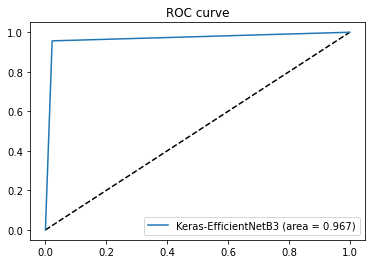

In [6]:
#Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras-EfficientNetB3 (area = {:.3f})'.format(auc))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()